In [1]:
import torch
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  


In [2]:
import bliss

from bliss.datasets.simulated import SimulatedDataset
from bliss.models.encoder import ImageEncoder

from bliss import device, use_cuda
print(device)
print(use_cuda)

data_path = Path('../data/')

cuda
True


In [3]:
torch.manual_seed(2342)
np.random.seed(354)

# Get data

In [4]:
# create training dataset
n_bands = 2
slen = 50

In [5]:
# set background
background = torch.zeros(n_bands, slen, slen, device=device)
background[:] = 686.0

In [6]:
# psf parameters 
psf_file = data_path.joinpath("fitted_powerlaw_psf_params.npy")
psf_params = torch.from_numpy(np.load(psf_file)).to(device)

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [ ]:
dec_args = (None, psf_params, background)

decoder_kwargs = dict(n_bands=n_bands,
                    slen=slen,
                    prob_galaxy=0.0,
                    max_sources=10,
                    mean_sources=5,
                    min_sources=5,
                    loc_min=0.0,
                    loc_max=1.0,
                    f_min=1e4,
                    f_max=1e6,
                    alpha=0.5,
                    add_noise=True)

In [8]:
batchsize = 4
dataset = SimulatedDataset(20, batchsize, dec_args, decoder_kwargs)

In [9]:
batch_params = dataset.get_batch()

In [10]:
for i in range(batchsize): 
    plt.matshow(batch_params['images'][i, 0].detach().cpu())
    plt.scatter(batch_params['locs'][i, :, 1].cpu() * (slen - 1), 
                batch_params['locs'][i, :, 0].cpu() * (slen - 1), 
               color = 'r', marker = 'x')

# Define encoder and get tiles

We divide the 50 x 50 image into four tiles

In [11]:
ptile_slen = 25
encoder = ImageEncoder(slen=slen,
                        ptile_slen=8,
                        tile_slen=2,
                        n_bands=n_bands,
                        max_detections=2,
                        n_galaxy_params=8,
                        enc_conv_c=20,
                        enc_kern=3,
                        enc_hidden=256,
                        momentum=0.5)

In [12]:
true_locs = batch_params['locs']
true_galaxy_params = batch_params['galaxy_params']
true_log_fluxes = batch_params['log_fluxes']
true_galaxy_bool = batch_params['galaxy_bool']

In [13]:
(true_tile_n_sources,
    true_tile_locs,
    true_tile_galaxy_params,
    true_tile_log_fluxes,
    true_tile_galaxy_bool,
    true_tile_is_on_array, 
) = encoder.get_params_in_tiles(
    slen, true_locs, true_galaxy_params, true_log_fluxes, true_galaxy_bool
)

# Plot the image tiles

In [14]:
batch_params['images'].shape

torch.Size([4, 2, 50, 50])

In [23]:
image_tiles = encoder.get_images_in_tiles(batch_params['images'])

In [24]:
n_tiles_per_image = encoder.tile_coords.shape[0]

In [29]:
true_tile_locs.shape

torch.Size([1936, 2, 2])

In [ ]:
for i in range(image_tiles.shape[0]): 
    fig, ax = plt.subplots(1, 2, figsize = (8, 8))
    # get full image
    indx = i // n_tiles_per_image
    image = batch_params['images'][indx, 0]
    
    # plot image tile
    n_src = int(true_tile_n_sources[i].cpu().numpy())
    ax[0].matshow(image_tiles[i, 0].detach().cpu(), vmax = image.max(), vmin = image.min())
    ax[0].set_title('image ' + str(i // n_tiles_per_image) + 
                    '; tile ' + str(i % n_tiles_per_image) + 
                    '; n_src ' + str(n_src) + '\n')
    
#     # plot stars 
#     which_star = (true_tile_galaxy_bool[i] == 0) & (true_tile_is_on_array[i] == 1)
#     ax[0].scatter(true_tile_locs[i, which_star, 1] * ptile_slen - 0.5, 
#                   true_tile_locs[i, which_star, 0] * ptile_slen - 0.5, 
#                   color = 'red', marker = 'x')
    
#     # plot full image
#     ax[1].matshow(image)
#     ax[1].set_title('image ' + str(i // n_tiles_per_image) + '\n')
#     ax[1].axvline(ptile_slen, color = 'white')
#     ax[1].axhline(ptile_slen, color = 'white')
    
#     # plot galaxies
#     ax[1].scatter(true_locs[indx, true_galaxy_bool[indx] == 1, 1] * (slen -1), 
#                   true_locs[indx, true_galaxy_bool[indx] == 1, 0] * (slen -1), 
#                   color = 'green', marker = 'x')
    
#     # plot stars 
#     ax[1].scatter(true_locs[indx, true_galaxy_bool[indx] == 0, 1] * (slen -1), 
#                   true_locs[indx, true_galaxy_bool[indx] == 0, 0] * (slen -1), 
#                   color = 'red', marker = 'x')


/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


# Get reconstruction on each tile. Should be similar

In [18]:
tile_background = torch.zeros(n_bands, ptile_slen, ptile_slen, device=device)
tile_background[0] = 686.0  

In [19]:
# simulator, but returns images of size ptile_slen
tile_source_simulator = \
    simulated_datasets.SourceSimulator(
            DecoderSamples(galaxy_slen, galaxy_decoder_file, n_bands=n_bands),
            get_fitted_powerlaw_psf(psf_file)[0:n_bands],
            tile_background, 
            slen = ptile_slen)

In [20]:
# simulate single galaxies from tile galaxy params
single_galaxies = tile_source_simulator.galaxy_decoder.dec(
                    true_tile_galaxy_params.reshape(-1, encoder.n_galaxy_params))[0].detach()

# reshape and apply galaxy booleon
single_galaxies = single_galaxies.reshape(true_tile_galaxy_params.shape[0], 
                        -1, 
                        n_bands, 
                        tile_source_simulator.galaxy_slen, 
                        tile_source_simulator.galaxy_slen) * \
                        true_tile_galaxy_bool.unsqueeze(2).unsqueeze(3).unsqueeze(4)

# trim single galaxies to be of smaller shape 
center_indx = (tile_source_simulator.galaxy_slen - 1) / 2

r = np.floor(ptile_slen / 2)
l_indx = int(center_indx - r)
u_indx = int(center_indx + r + 1)

single_galaxies = single_galaxies[:, :, :, l_indx:u_indx, l_indx:u_indx]

In [21]:
# parameterization on tiles for locs is *slightly* different ... 
_true_tile_locs = (true_tile_locs * ptile_slen - 0.5) / (ptile_slen - 1)

In [22]:
# reconstrct image on tiles
recon_tile_images = tile_source_simulator._draw_image_from_params(true_tile_n_sources, 
                                            _true_tile_locs * true_tile_galaxy_bool.unsqueeze(-1), 
                                            _true_tile_locs * (1 - true_tile_galaxy_bool).unsqueeze(-1), 
                                            single_galaxies, 
                                            torch.exp(true_tile_log_fluxes.unsqueeze(-1))) + 686.

Qualitatively, the reconstructions look similar. But the galaxies have a wierd "ring" in the residuals. I *suspect* this is due to the differences in convoluting the single galaxy images on the smaller ptiles verses convoluting the singe galaxy images on the full image. 

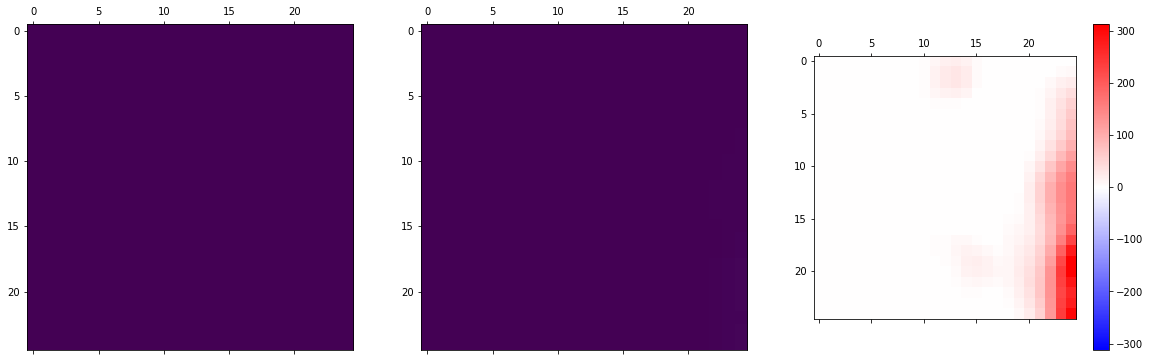

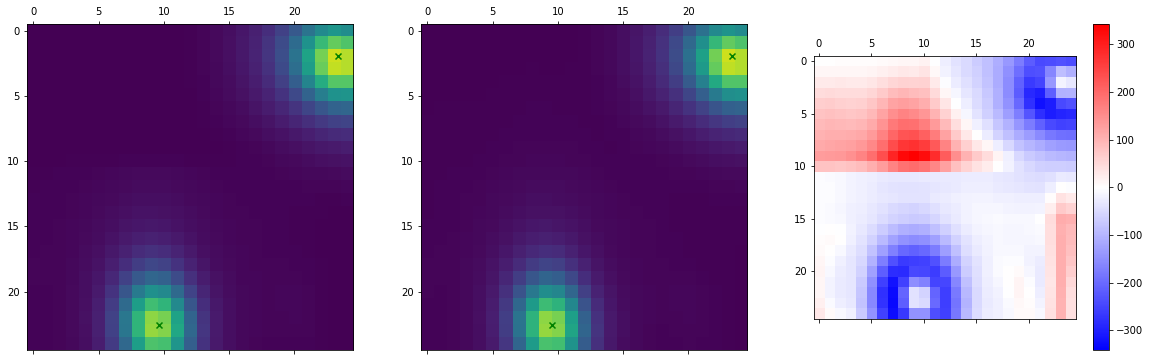

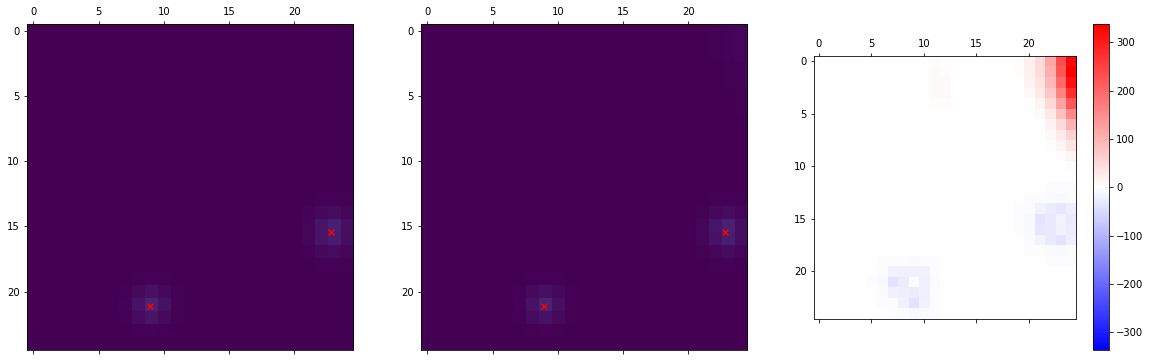

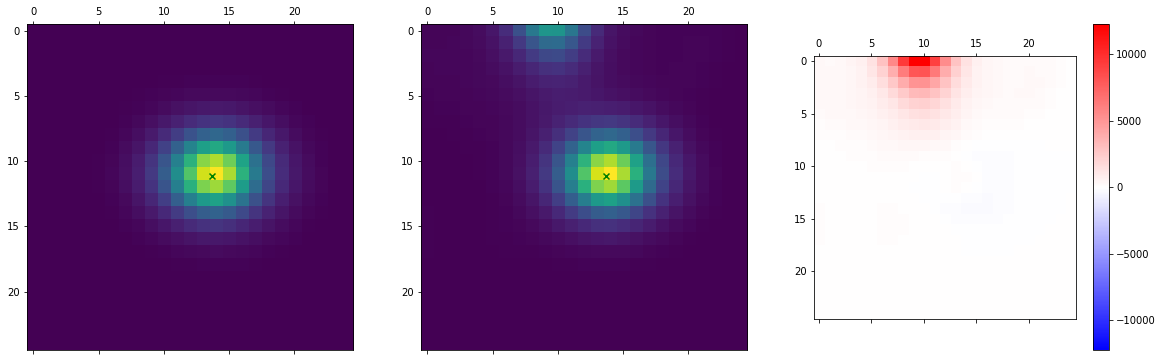

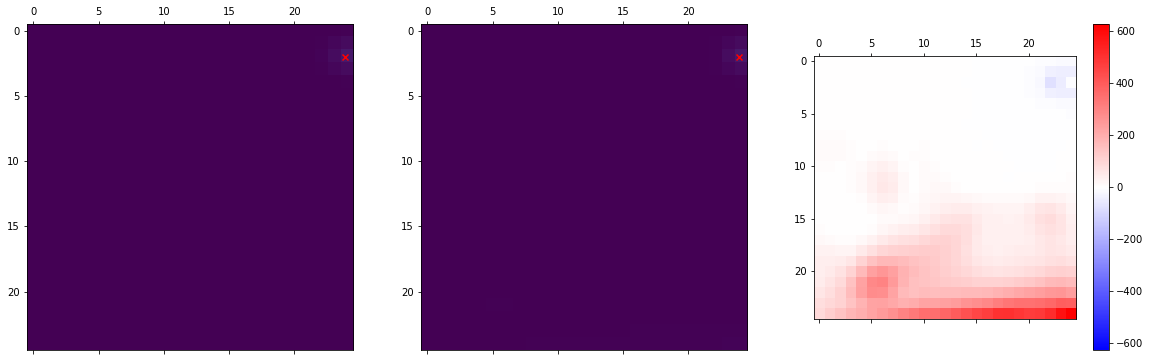

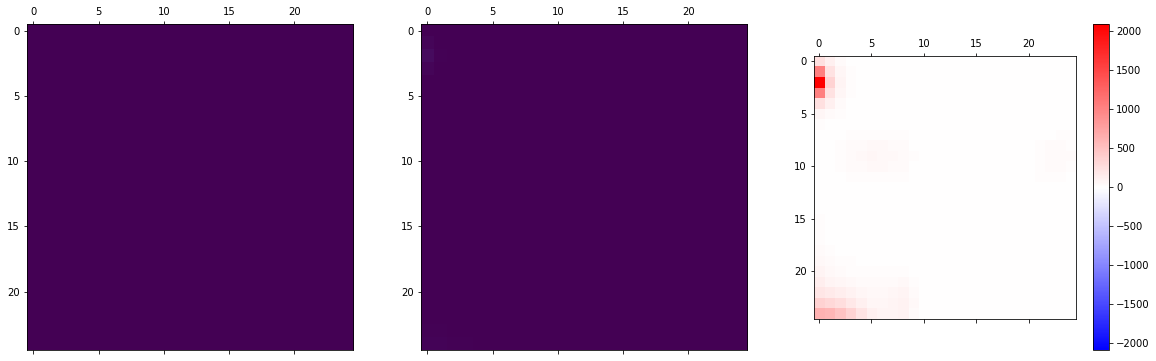

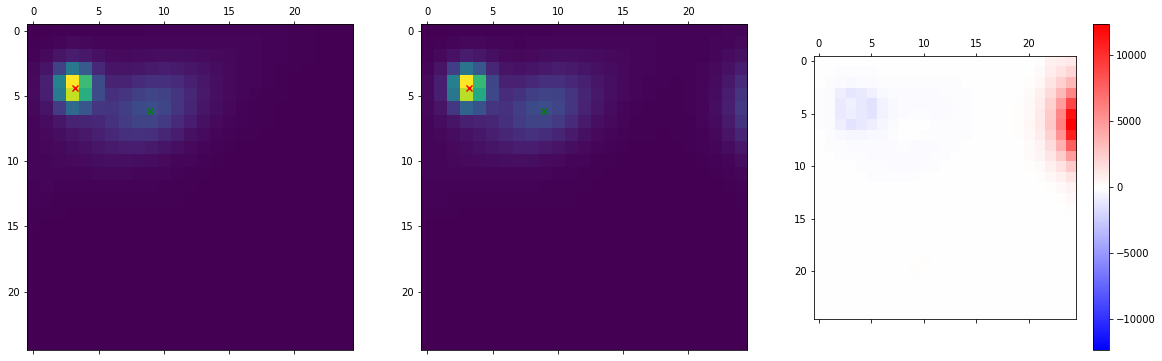

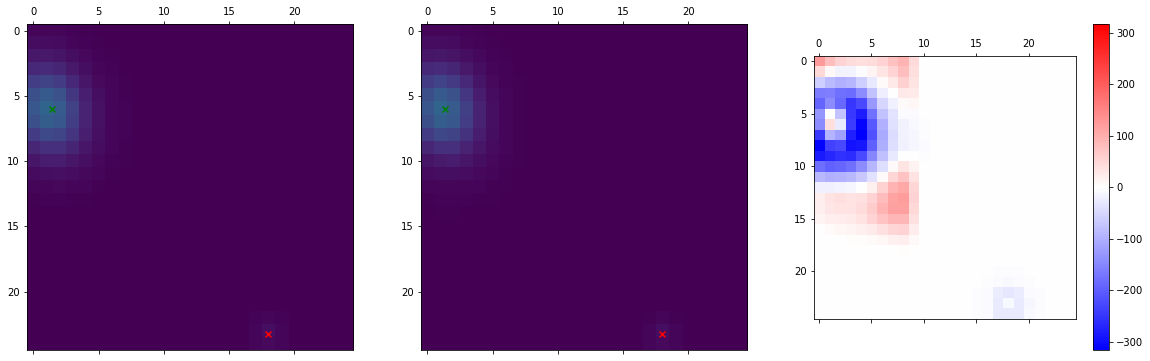

In [23]:
for i in range(image_tiles.shape[0]): 
    fig, ax = plt.subplots(1, 3, figsize = (20, 6))
    # get full image
    indx = i // n_tiles_per_image
    image = batch_params['images'][indx, 0]
    
    # plot reconstructed image tile
    n_src = int(true_tile_n_sources[i].numpy())
    ax[0].matshow(recon_tile_images[i, 0], vmax = image.max(), vmin = image.min())
    
    # plot true image tile
    ax[1].matshow(image_tiles[i, 0], vmax = image.max(), vmin = image.min())
    
    resid = image_tiles[i, 0] - recon_tile_images[i, 0]
    im1 = ax[2].matshow(resid, 
                  vmax = resid.abs().max(), vmin = -resid.abs().max(), 
                  cmap = plt.get_cmap('bwr'))
    fig.colorbar(im1, ax = ax[2])
        
    # plot galaxies
    for k in range(2): 
        ax[k].scatter(true_tile_locs[i, true_tile_galaxy_bool[i] == 1, 1] * ptile_slen - 0.5, 
                      true_tile_locs[i, true_tile_galaxy_bool[i] == 1, 0] * ptile_slen - 0.5, 
                      color = 'green', marker = 'x')

        # plot stars 
        which_star = (true_tile_galaxy_bool[i] == 0) & (true_tile_is_on_array[i] == 1)
        ax[k].scatter(true_tile_locs[i, which_star, 1] * ptile_slen - 0.5, 
                      true_tile_locs[i, which_star, 0] * ptile_slen - 0.5, 
                      color = 'red', marker = 'x')

# Go convert tile parameters back to full image

In [28]:
# only look at first image
(true_tile_n_sources,
    true_tile_locs,
    true_tile_galaxy_params,
    true_tile_log_fluxes,
    true_tile_galaxy_bool,
    true_tile_is_on_array,
    ) = encoder.get_params_in_tiles(
            slen, true_locs[0:1], true_galaxy_params[0:1], true_log_fluxes[0:1], true_galaxy_bool[0:1]
            )

true_tile_log_fluxes = true_tile_log_fluxes.unsqueeze(-1)

In [29]:
(n_sources, locs, galaxy_params, log_fluxes, galaxy_bool) = \
            encoder._get_full_params_from_sampled_params(
            slen,
            true_tile_is_on_array.unsqueeze(0),
            true_tile_locs.unsqueeze(0),
            true_tile_galaxy_params.unsqueeze(0),
            true_tile_log_fluxes.unsqueeze(0),
            true_tile_galaxy_bool.unsqueeze(0).unsqueeze(-1),
        )

In [30]:
# compare our untiled locs with the original locs
# sort so they match up
print(locs[0])
print(true_locs[0])

locs1 = locs[0, torch.argsort(locs[0, :, 0]), :]
locs2 = true_locs[0, torch.argsort(true_locs[0, :, 0]), :]

assert(torch.abs(locs1 - locs2).max() < 1e-6)

tensor([[0.4602, 0.7059],
        [0.0398, 0.9872],
        [0.7376, 0.7900],
        [0.8253, 0.4658],
        [0.9406, 0.1820]])
tensor([[0.9406, 0.1820],
        [0.0398, 0.9872],
        [0.4602, 0.7059],
        [0.7376, 0.7900],
        [0.8253, 0.4658]])


In [31]:
# check pattern of galaxy params
assert torch.all((galaxy_params * galaxy_bool) == galaxy_params)
assert torch.all((galaxy_params * (1 - galaxy_bool)) == 0)

In [32]:
gal_params1 = galaxy_params[0, galaxy_bool.squeeze() == 1, :]
gal_params2 = true_galaxy_params[0, true_galaxy_bool[0] == 1, :]

print(gal_params1)
print('\n')
print(gal_params2)

assert torch.all(torch.abs(gal_params1[torch.argsort(gal_params1[:, 0])] - 
                           gal_params2[torch.argsort(gal_params2[:, 0])]) < 1e-6)

tensor([[ 0.0373, -0.8360,  0.3834, -2.0910, -0.2000,  0.5883, -0.2006,  1.0903],
        [-1.1751, -1.3896,  1.4221,  0.8151,  1.0985, -1.2909, -0.3891,  1.1247],
        [ 0.1772, -0.1311,  1.1044,  1.1177,  1.7602, -0.1053,  0.5716, -1.9422]])


tensor([[-1.1751, -1.3896,  1.4221,  0.8151,  1.0985, -1.2909, -0.3891,  1.1247],
        [ 0.0373, -0.8360,  0.3834, -2.0910, -0.2000,  0.5883, -0.2006,  1.0903],
        [ 0.1772, -0.1311,  1.1044,  1.1177,  1.7602, -0.1053,  0.5716, -1.9422]])


In [33]:
# check pattern of log-fluxes
assert torch.all((log_fluxes * galaxy_bool) == 0)
assert torch.all((log_fluxes * (1 - galaxy_bool)) == log_fluxes)

In [34]:
flux_params1 = log_fluxes[0, galaxy_bool.squeeze() == 0, :]
flux_params2 = true_log_fluxes[0, true_galaxy_bool[0] == 0, :]

print(flux_params1)
print('\n')
print(flux_params2)

assert torch.all(torch.abs(flux_params1[torch.argsort(flux_params1[:, 0])] - 
                           flux_params2[torch.argsort(flux_params2[:, 0])]) < 1e-6)

tensor([[9.6488],
        [9.4390]])


tensor([[9.4390],
        [9.6488]])


# Check reconstruction, just for completeness

In [35]:
single_galaxies = dataset.simulator.galaxy_decoder.dec(
                    galaxy_params.reshape(-1, encoder.n_galaxy_params))[0].detach()

# reshape and apply galaxy booleon
single_galaxies = single_galaxies.reshape(galaxy_params.shape[0], 
                        -1, 
                        n_bands, 
                        dataset.simulator.galaxy_slen, 
                        dataset.simulator.galaxy_slen) * \
                        galaxy_bool.unsqueeze(-1).unsqueeze(-1)

In [36]:
# reconstrct image on tiles
recon_image = dataset.simulator._draw_image_from_params(n_sources, 
                                            locs * galaxy_bool, 
                                            locs * (1 - galaxy_bool), 
                                            single_galaxies, 
                                            torch.exp(log_fluxes)) + 686.

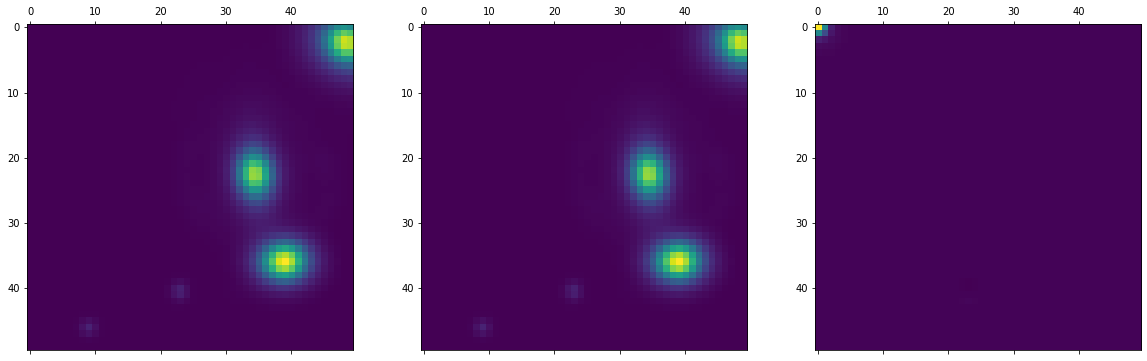

In [37]:
fig, ax = plt.subplots(1, 3, figsize = (20, 6))

# plot reconstructed image 
ax[0].matshow(recon_image[0, 0])

# plot original image
ax[1].matshow(batch_params['images'][0, 0])

ax[2].matshow(recon_image[0, 0] - batch_params['images'][0, 0])